In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/nepslor/teaching/main/TimeSeriesForecasting/data/outliers.csv', index_col=0)

Estimated coefficients:
a1 ≈ 0.00253515, b1 ≈ 61.34453782
a2 ≈ 0.00262809, b2 ≈ 440.20100503


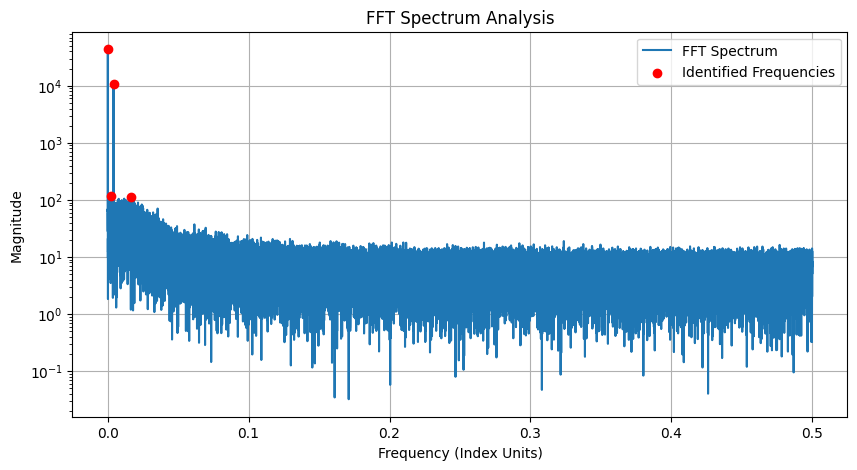

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Extract the first column as y-values (assuming no header, adjust if needed)
y = df.iloc[:, 0].values  # First column
x = np.arange(len(y))  # Use index as x-coordinates

# Remove DC component (vertical shift)
y_detrended = y - np.mean(y)  # Subtract mean to center at 0

# Compute FFT
N = len(y)
yf = fft(y_detrended)
xf = fftfreq(N, 1)  # Frequency axis (1 since we don't know actual time steps)

# Consider only positive frequencies
idx = np.where(xf > 0)
xf_pos = xf[idx]
yf_pos = np.abs(yf[idx])

# Identify the two strongest frequency peaks
sorted_indices = np.argsort(yf_pos)[-4:]  # Get top two peaks
freqs = xf_pos[sorted_indices]
amps = yf_pos[sorted_indices] / (N / 2)  # Normalize amplitudes

# Extract estimated parameters
b1_est, b2_est,f,g = freqs
a1_est, a2_est,q,r = amps

# Print the estimated coefficients
print(f"Estimated coefficients:")
print(f"a1 ≈ {a1_est:.8f}, b1 ≈ {1/b1_est:.8f}")
print(f"a2 ≈ {a2_est:.8f}, b2 ≈ {1/b2_est:.8f}")

# Plot the frequency spectrum
plt.figure(figsize=(10, 5))
plt.plot(xf_pos, yf_pos, label="FFT Spectrum")
plt.scatter(freqs, amps * (N / 2), color='red', label="Identified Frequencies", zorder=3)
plt.xlabel("Frequency (Index Units)")
plt.ylabel("Magnitude")
plt.yscale('log')
plt.title("FFT Spectrum Analysis")
plt.legend()
plt.grid()
plt.show()


In [41]:
import plotly.graph_objects as go

# Generate the estimated function
n = 87600
t = np.linspace(1, n,n)
y_est = 0.25+a1_est * np.sin(2*np.pi*b1_est * t+4.5) + a2_est * np.sin(2*np.pi*b2_est * t)

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y_est, mode='lines', name='Estimated Function'))
fig.add_trace(go.Scatter(x=np.arange(len(y)), y=y, mode='lines', name='Original Function'))

# Update layout
fig.update_layout(
    title="Estimated Function",
    xaxis_title="Time",
    yaxis_title="Magnitude",
    template="plotly_white"
)

# Show the plot
fig.show()

In [52]:
# given this function: y_est = 0.25+a1_est * np.sin(2*np.pi*b1_est * t+4.5) + a2_est * np.sin(2*np.pi*b2_est * t), find a method to fit the 0.25 and 4.5 values in a way that the function fits the original data as close as possible.
from scipy.optimize import minimize

# Define the function to optimize
def func_to_optimize(params):
    a1, b1, a2, b2, c, d = params
    y_est = c + a1 * np.sin(2 * np.pi * b1 * x + d) + a2 * np.sin(2 * np.pi * b2 * x)
    return np.sum((y - y_est) ** 2)

# Initial guess
params0 = [a1_est, b1_est, a2_est, b2_est, 0.25, 4.49]

# Perform optimization
res = minimize(func_to_optimize, params0, method='L-BFGS-B')

# Extract the optimized parameters
a1_opt, b1_opt, a2_opt, b2_opt, c_opt, d_opt = res.x

# Print the optimized parameters
print(f"Optimized coefficients:")
print(f"a1 ≈ {a1_opt:.8f}, b1 ≈ {b1_opt:.8f}")
print(f"a2 ≈ {a2_opt:.8f}, b2 ≈ {b2_opt:.8f}")
print(f"c ≈ {c_opt:.8f}, d ≈ {d_opt:.8f}")

Optimized coefficients:
a1 ≈ 0.25041355, b1 ≈ 0.00416728
a2 ≈ 1.00022731, b2 ≈ 0.00011415
c ≈ 0.25000000, d ≈ 4.49000000


In [53]:
# Print the optimized parameters
print(f"Optimized coefficients:")
print(f"a1 ≈ {a1_opt:.8f}, b1 ≈ {b1_opt:.8f}")
print(f"a2 ≈ {a2_opt:.8f}, b2 ≈ {b2_opt:.8f}")
print(f"c ≈ {c_opt:.8f}, d ≈ {d_opt:.8f}")

# Generate the optimized function
y_opt = c_opt + a1_opt * np.sin(2 * np.pi * b1_opt * t + d_opt) + a2_opt * np.sin(2 * np.pi * b2_opt * t)

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y_opt, mode='lines', name='Optimized Function'))
fig.add_trace(go.Scatter(x=np.arange(len(y)), y=y, mode='lines', name='Original Function'))

# Update layout
fig.update_layout(
    title="Optimized Function",
    xaxis_title="Time",
    yaxis_title="Magnitude",
    template="plotly_white"
)

# Show the plot
fig.show()

Optimized coefficients:
a1 ≈ 0.25041355, b1 ≈ 0.00416728
a2 ≈ 1.00022731, b2 ≈ 0.00011415
c ≈ 0.25000000, d ≈ 4.49000000


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Define the reconstructed clean function
def reconstructed_signal(x, a1, b1, a2, b2,c,d):
    return c+a1 * np.sin(2 * np.pi * b1 * x+d) + a2 * np.sin(2 * np.pi * b2 * x)


# Extract first column as signal
y_noisy = df.iloc[:, 2].values  # Original noisy signal
x = np.arange(len(y_noisy))  # Using index as x-axis

# Use estimated coefficients from FFT analysis
a1, b1,a2, b2,c,d = a1_opt, b1_opt, a2_opt, b2_opt, c_opt, d_opt  # Replace with your FFT-estimated values # Replace with your FFT-estimated values

# Generate the clean sine function
y_clean = reconstructed_signal(x, a1, b1, a2, b2, c, d)

# Compute the noise (residuals)
noise = y_noisy - y_clean

# Detect outliers using Interquartile Range (IQR)
Q1, Q3 = np.percentile(noise, [22, 78])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (noise < lower_bound) | (noise > upper_bound)

# Replace outliers with a median filter (or use interpolation)
noise_filtered = np.copy(noise)
noise_filtered[outliers] = medfilt(noise, kernel_size=5)[outliers]

# Generate the cleaned signal
y_denoised = y_clean + noise_filtered

import plotly.graph_objects as go

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y_noisy, mode='lines', name='Noisy Data', opacity=0.5))
fig.add_trace(go.Scatter(x=x, y=y_denoised, mode='lines', name='Denoised Data', line=dict(color='red')))

# Update layout
fig.update_layout(
    title="Noise Filtering with Outlier Removal",
    xaxis_title="Index",
    yaxis_title="Signal Value",
    template="plotly_white",
    height=500
)

# Show the plot
fig.show()


In [89]:
#count the points that you removed
print(f"Number of outliers removed: {np.sum(outliers)}")


Number of outliers removed: 732


In [87]:
#outliers index
outliers_index = np.where(outliers)
print(outliers_index)

(array([   80,   137,   142,   328,   386,   409,   509,   882,   999,
        1199,  1346,  1564,  1604,  1967,  1988,  2014,  2339,  2463,
        2536,  2561,  2722,  3095,  3125,  3198,  3199,  3200,  3201,
        3202,  3307,  3448,  3540,  3873,  3954,  4254,  4568,  4975,
        4982,  4991,  5121,  5314,  5315,  5346,  5804,  6199,  6453,
        6568,  6628,  6821,  7096,  7145,  7256,  7270,  7497,  7659,
        7728,  7743,  7762,  7772,  7957,  8068,  8337,  8457,  8524,
        8695,  8807,  8823,  9311,  9312,  9313,  9397,  9546,  9681,
        9686,  9886,  9909, 10528, 10581, 10768, 10961, 11006, 11018,
       11058, 11217, 11502, 11666, 11765, 12021, 12237, 12389, 12418,
       13353, 13739, 13901, 13996, 14110, 14254, 14273, 14419, 14466,
       14520, 14573, 15053, 15353, 15440, 15655, 15687, 16244, 16585,
       16649, 17050, 17070, 17100, 17353, 17434, 17608, 17695, 18054,
       18064, 18245, 18272, 18336, 18356, 18558, 18597, 18899, 19003,
       19380, 19506